- Load Kalman Data
- Load Video
- Align Timestamps\
- align "0" distance from ground plane on kalman\
- For each frame in video, let POS = closest kalman timestep\
- project points from "depth" where depth is render of ground plane - to test this, produce video of ground plane from phone orientation\
- rotate pointcloud and render from above
- use SIFT to transform it into relative position of first image



In [1]:
import os
import cv2
import numpy as np
import cupy as cp
from ultralytics import YOLO
import matplotlib.pyplot as plt
import sys
from PIL import Image
from importlib import reload
import pandas as pd
import plotly.express as px
import gdown
import zipfile

sys.path.insert(1, '..')
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

In [2]:
files = {
    'walk_to_malachowski' : 'https://drive.google.com/file/d/1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR/view?usp=drive_link',
    'walk_down_parking_lot' : 'https://drive.google.com/file/d/1RtRjmR7ggn5DgyxNK6mGkihZY-g9NyCq/view?usp=drive_link',
    'malachowski_chamomile' : 'https://drive.google.com/file/d/1V28HPGOMnI-l-GiAFGB5xzt0YajLtwMU/view?usp=drive_link',
    'malachowski_chamomile_2' : 'https://drive.google.com/file/d/1JD9SI-bM44BPeG2frwaznO2Fq97BAmUM/view?usp=drive_link',
    'first_test_walk' : 'https://drive.google.com/file/d/1u7FCFc4uaZscHvZ6wH9wU2pb_Mz9djPF/view?usp=drive_link'
}

def convert_to_direct_download(gdrive_link):
    start = gdrive_link.find('/d/') + 3
    end = gdrive_link.find('/view', start)
    file_id = gdrive_link[start:end]

    direct_download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

    return direct_download_url

# Load Data

In [3]:
# @title Selected File
selected = "walk_to_malachowski" # @param ["malachowski_chamomile", "malachowski_chamomile_2", "walk_to_malachowski", "first_test_walk", "walk_down_parking_lot"]

url = convert_to_direct_download(files[selected])
gdown.download(url, "of.zip")
with zipfile.ZipFile("./of.zip", 'r') as zip_ref:
    zip_ref.extractall("../Data/")

Downloading...
From (original): https://drive.google.com/uc?id=1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR&export=download
From (redirected): https://drive.google.com/uc?id=1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR&export=download&confirm=t&uuid=cbb3499d-84be-47c3-bb00-82b65e340576
To: c:\Users\c1a55\Documents\Roborouter\Notebooks\of.zip
100%|██████████| 536M/536M [00:08<00:00, 66.5MB/s] 


In [4]:
%cd ../data/
%cd $selected

c:\Users\c1a55\Documents\Roborouter\data
c:\Users\c1a55\Documents\Roborouter\data\walk_to_malachowski


In [71]:
AccelerometerDF = pd.read_csv('Accelerometer.csv')
print("🔴Accelerometer:")
print(AccelerometerDF.head(1))

BarometerDF = pd.read_csv('Barometer.csv')
print("🔵Barometer:")
print(BarometerDF.head(1))
#relativeAltitude
#pressure

LocationDF = pd.read_csv('Location.csv')
print("🟢Location:")
print(LocationDF.head(1))
#altitude
#speedAccuracy
#bearingAccuracy
#latitude
#altitudeAboveMeanSaLevel
#bearing
#horizontalAccuracy
#verticalAccuracy
#longitude
#speed

#To be used for synchronization
MicrophoneDF = pd.read_csv('Microphone.csv')
#print("Microphone:")
#print(MicrophoneDF.head(1))
#dBFS

#Prefused = best guess. Smoothing welcomed.
OrientationDF = pd.read_csv('Orientation.csv')
print("🟠Orientation:")
print(OrientationDF.head(1))
#yaw
#qx
#qz
#roll
#qw
#qy
#pitch

🔴Accelerometer:
                  time  seconds_elapsed         z         y         x
0  1707585936836849400         0.120849 -1.105513  0.109932 -0.172708
🔵Barometer:
                  time  seconds_elapsed  relativeAltitude     pressure
0  1707585936256298000        -0.459702               0.0  1016.647186
🟢Location:
                  time  seconds_elapsed  altitude  speedAccuracy  \
0  1707585908244470000        -28.47153  6.276319       1.207736   

   bearingAccuracy   latitude  altitudeAboveMeanSeaLevel  bearing  \
0             -1.0  29.644654                  35.686319     -1.0   

   horizontalAccuracy  verticalAccuracy  longitude     speed  
0            4.758735          3.343498 -82.345984  0.132651  
🟠Orientation:
                  time  seconds_elapsed       yaw        qx        qz  \
0  1707585936836849400         0.120849 -0.543345 -0.028643  0.269779   

       roll        qw        qy     pitch  
0 -0.096052 -0.960761  0.057768  0.086314  


110    11.313
111    11.417
112    11.521
113    11.624
114    11.729
115    11.829
116    11.929
117    12.029
118    12.129
119    12.230
120    12.330
121    12.432
122    12.532
123    12.634
124    12.735
125    12.841
126    12.946
127    13.047
128    13.146
129    13.248
Name: seconds_elapsed, dtype: float64
(145, 12)
(132, 4)
(14492, 5)


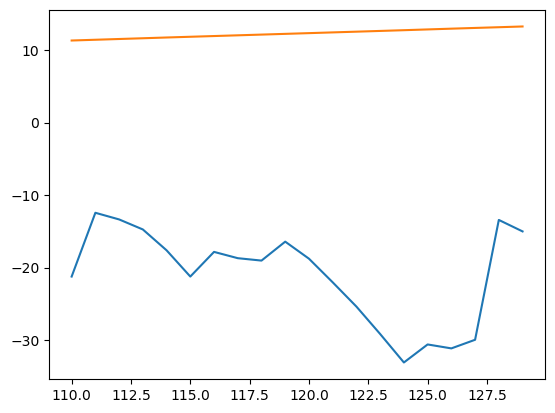

In [74]:
# Sync microphone tinmings with video playback:
videoPlaybackClapTimestamp = 3 + 24.5/30
#30fps, clap spotted at ~24/25 frames after 3 seconds elapsed, so clap two in malachowski occurs at video time of (3 + 24.5/30)

plt.plot((MicrophoneDF[['dBFS', 'seconds_elapsed']][110:130]))
#looks like the clap occurs at around index 123 to 126
print(MicrophoneDF['seconds_elapsed'][110:130])

#indeed, seems all our stuff starts around 12.5 seconds elapsed
secondsElapsedSync = 12.5

LocationDF = LocationDF[LocationDF['seconds_elapsed'] >= 12.5]
BarometerDF = BarometerDF[BarometerDF['seconds_elapsed'] >= 12.5]
AccelerometerDF = AccelerometerDF[AccelerometerDF['seconds_elapsed'] >= 12.5]

print(LocationDF.shape)
print(BarometerDF.shape)
print(AccelerometerDF.shape)


In [52]:
from scipy.spatial.transform import Rotation as R
pi = np.pi


ax, ay, az = 30, 0, 30  # Example acceleration vector
qx, qy, qz, qw = -0.07, -0.4, -0.06, 0.9  # Example quaternion (no rotation)


def convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw):
  Rquat = R.from_quat([qx, qy, qz, qw])
  rotation_matrix = Rquat.as_matrix()
  inv = rotation_matrix.T
  result = inv @ [ax, ay, az]
  return result

convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw)
#definitely correct as fuck.

array([       42.3,      2.6367,     -1.9285])

## Validate Accelerations Visually

In [61]:
#Preprocessing the accelerations into ENU accelerations using the phone rotation:

def convert_accelerations(accel_df, orient_df):
    returnme = accel_df.copy(deep=True)

    # Initialize a copy
    returnme.rename(
        mapper = {'x':'north', 'y':'east', 'z':'up'},
        axis='columns',
        inplace=True
    )

    for i in range(len(accel_df)):
        # Create a rotation object from the roll, pitch, and yaw

        ax = accel_df.iloc[i]["x"] #still x,y,z
        ay = accel_df.iloc[i]["y"]
        az = accel_df.iloc[i]["z"]


        qw = orient_df.iloc[i]["qw"]
        qx = orient_df.iloc[i]["qx"]
        qy = orient_df.iloc[i]["qy"]
        qz = orient_df.iloc[i]["qz"]

        north, east, up = convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw)

        returnme.loc[i, "north"] = north
        returnme.loc[i, "east"] = east
        returnme.loc[i, "up"] = up
    
    return returnme



print(AccelerometerDF.head(3))
AccelerometerENUDF=convert_accelerations(AccelerometerDF, OrientationDF)
print(AccelerometerENUDF.head(3))

                  time  seconds_elapsed         z         y         x
0  1707585936836849400         0.120849 -1.105513  0.109932 -0.172708
1  1707585936846874400         0.130874 -0.984158  0.009005 -0.031572
2  1707585936856900400         0.140900 -0.622699 -0.213101  0.081729
                  time  seconds_elapsed        up      east     north
0  1707585936836849400         0.120849 -1.077105 -0.090511 -0.309396
1  1707585936846874400         0.130874 -0.972004 -0.096927 -0.124329
2  1707585936856900400         0.140900 -0.621109 -0.197196  0.123217


# Just visualizing the integrated acceleration data.
Its not great, but it does represent the course

In [67]:
def integrate_acceleration_to_position(df):
    # Assume df is your DataFrame with columns: time, seconds_elapsed, up, east, north
    
    # Calculate the differences in time to get dt
    dt = df['seconds_elapsed'].diff().fillna(0)  # Using fillna(0) for the first value
    
    # Initialize columns for velocity and position
    for axis in ['up', 'east', 'north']:
        df[f'velocity_{axis}'] = 0
        df[f'position_{axis}'] = 0
    
    # Calculate velocity and position using the trapezoidal rule for integration
    for i in range(1, len(df)):
        for axis in ['up', 'east', 'north']:
            # Integrate acceleration to find velocity
            df.loc[i, f'velocity_{axis}'] = df.loc[i-1, f'velocity_{axis}'] + 0.5 * (df.loc[i, axis] + df.loc[i-1, axis]) * dt.iloc[i]
            
            # Integrate velocity to find position
            df.loc[i, f'position_{axis}'] = df.loc[i-1, f'position_{axis}'] + 0.5 * (df.loc[i, f'velocity_{axis}'] + df.loc[i-1, f'velocity_{axis}']) * dt.iloc[i]
    
    # Select only the position columns for the result
    position_columns = [col for col in df.columns if 'position' in col]
    return df[position_columns]


int_location_df = integrate_acceleration_to_position(AccelerometerENUDF)

fig = px.line_3d(
    int_location_df,
    x=int_location_df['position_north'][1:1000],
    y=int_location_df['position_east'][1:1000],
    z=int_location_df['position_up'][1:1000]
)
fig.layout.scene.aspectmode='data'
fig.show()

In [68]:
import pymap3d as pm
# The local coordinate origin (Zermatt, Switzerland)
lat0 = LocationDF["latitude"][0] # deg
lon0 = LocationDF["longitude"][0]  # deg
h0 = LocationDF["altitude"][0]     # meters

def convert_to_enu(row):
    east, north, up = pm.geodetic2enu(row['latitude'], row['longitude'], row['altitude'], lat0, lon0, h0)
    return pd.Series([east, north, up])

# Apply the function to each row and create new columns
ENULocDF=LocationDF.copy(deep=True)
ENULocDF[['east', 'north', 'up']] = LocationDF.apply(convert_to_enu, axis=1)

In [69]:
# for creating a responsive plot
fig = px.line_3d(ENULocDF, x=ENULocDF['north'], y=ENULocDF['east'], z=ENULocDF['up'])
fig.show()

# Perform Kalman Filtering

In [21]:
import numpy as np
delta_t = 1/100  # Time step for 100Hz frequency
initial_state = np.zeros(6)  # [east_pos, north_pos, up_pos, east_vel, north_vel, up_vel]
transition_matrix = np.array([
    [1, 0, 0, delta_t, 0, 0],
    [0, 1, 0, 0, delta_t, 0],
    [0, 0, 1, 0, 0, delta_t],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

state_covariance = np.eye(6) * 100
state_covariance_combined = np.eye(6) * 100
process_noise = np.eye(6) * 0.01 

average_acceleration = ENUAccelDF[['east', 'north', 'up']].abs().mean()
measurement_noise_accel = np.array([
    [average_acceleration['east']*.01, 0, 0], #Iphone docs say 1% measurement error. We crank artificially
    [0, average_acceleration['north']*.01, 0],
    [0, 0, average_acceleration['up']*.01],
])
measurement_noise_gps = np.eye(3) * 3  # GPS measurement noise
observation_matrix_accel = np.array([
    [0, 0, 0, 1, 0, 0],  # east_pos
    [0, 0, 0, 0, 1, 0],  # north_pos
    [0, 0, 0, 0, 0, 1],  # up_pos
])

observation_matrix_gps = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

measurement_noise_combined = np.block([
    [measurement_noise_gps, np.zeros((3, 3))],
    [np.zeros((3, 3)), measurement_noise_accel]
])

observation_matrix_combined = np.block([
    [observation_matrix_gps, np.zeros((3, 3))],
    [np.zeros((3, 3)), np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        ])
     ]
])

state = np.zeros(6)

dict = {'east':[], 'north':[], 'up':[]}
outputCoords = pd.DataFrame(dict)
print(ENUAccelDF.shape)
# Kalman filter loop
for index, accel_row in enumerate(zip(ENUAccelDF.iterrows())):
    print(f"Before update: State (velocities) = {state[3:]}")
    # Update state and state covariance here based on the transition matrix and process noise
    state = transition_matrix.dot(state)
    state_covariance = transition_matrix.dot(state_covariance).dot(transition_matrix.T) + process_noise

    if index % 100 == 0:
        print("GPS Update 🚨")
        # GPS data is available
        try:
            loc_row = ENULocDF.iloc[index // 100]
        except Exception as e:
            print(e)
            break
        observation_vector = np.concatenate((np.array([loc_row['east'], loc_row['north'], loc_row['up']]), np.array([accel_row[0][1]['east'], accel_row[0][1]['north'], accel_row[0][1]['up']])))
        observation_matrix = observation_matrix_combined
        measurement_noise = measurement_noise_combined
        S = observation_matrix.dot(state_covariance).dot(observation_matrix.T) + measurement_noise  # 6x6 matrix
        K = state_covariance.dot(observation_matrix.T).dot(np.linalg.inv(S))  # K will be 6x6
    else:
        # Only accelerometer data is available
        observation_vector = np.array([accel_row[0][1]['east'], accel_row[0][1]['north'], accel_row[0][1]['up']])
        observation_matrix = observation_matrix_accel
        measurement_noise = measurement_noise_accel

        S = observation_matrix.dot(state_covariance).dot(observation_matrix.T) + measurement_noise  # 3x3 matrix for accel
        K = state_covariance.dot(observation_matrix.T).dot(np.linalg.inv(S))  # K will be 6x3 for accel


    state = state + K.dot(observation_vector - observation_matrix.dot(state))

    # Update state covariance
    state_covariance = (np.eye(len(state)) - K.dot(observation_matrix)).dot(state_covariance)

    outputCoords.loc[len(outputCoords.index)] = state[0:3]
    print(f"After update: State (velocities) = {state[3:]}")

(15727, 3)
Before update: State (velocities) = [          0           0           0]
GPS Update 🚨
After update: State (velocities) = [    -0.0905    -0.30937     -1.0769]
Before update: State (velocities) = [    -0.0905    -0.30937     -1.0769]
After update: State (velocities) = [  -0.094663    -0.18556     -1.0112]
Before update: State (velocities) = [  -0.094663    -0.18556     -1.0112]
After update: State (velocities) = [   -0.15596   0.0084803    -0.79066]
Before update: State (velocities) = [   -0.15596   0.0084803    -0.79066]
After update: State (velocities) = [   -0.27697     0.16433    -0.41019]
Before update: State (velocities) = [   -0.27697     0.16433    -0.41019]
After update: State (velocities) = [   -0.35617     0.26172    0.011325]
Before update: State (velocities) = [   -0.35617     0.26172    0.011325]
After update: State (velocities) = [   -0.40432     0.31385     0.31407]
Before update: State (velocities) = [   -0.40432     0.31385     0.31407]
After update: State 

In [22]:
# Add a 'source' column to each DataFrame to distinguish them in the plot
ENULocDF['source'] = 'GPS'
outputCoords['source'] = 'Kalman Filter'

# Combine the two DataFrames
combined_df = pd.concat([ENULocDF.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'}),
                         outputCoords.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'})])

# Plot using Plotly Express
fig = px.line_3d(combined_df, x='X', y='Y', z='Z', color='source')
fig.layout.scene.aspectmode='data'
fig.show()

In [12]:
print(outputCoords.head(5)) #east north up source
print(OrientationDF.head(5))

print(outputCoords.shape)
print(OrientationDF.shape)




       east     north        up         source
0 -0.000026 -0.000090 -0.000314  Kalman Filter
1 -0.000931 -0.003184 -0.011085  Kalman Filter
2 -0.001901 -0.004427 -0.020805  Kalman Filter
3 -0.003873 -0.003195 -0.027016  Kalman Filter
4 -0.007485 -0.000608 -0.028050  Kalman Filter
                  time  seconds_elapsed       yaw        qx        qz  \
0  1707585936836849400         0.120849 -0.543345 -0.028643  0.269779   
1  1707585936846874400         0.130874 -0.545215 -0.030435  0.270720   
2  1707585936856900400         0.140900 -0.547201 -0.032495  0.271718   
3  1707585936866925600         0.150926 -0.549221 -0.034340  0.272721   
4  1707585936876950500         0.160950 -0.551121 -0.035765  0.273654   

       roll        qw        qy     pitch  
0 -0.096052 -0.960761  0.057768  0.086314  
1 -0.094900 -0.960445  0.057710  0.089830  
2 -0.093506 -0.960102  0.057607  0.093840  
3 -0.092129 -0.959762  0.057459  0.097411  
4 -0.090964 -0.959453  0.057302  0.100158  
(15727, 4)
(157